<a href="https://colab.research.google.com/github/AnLiMan/RNN_AnD_NN/blob/main/RNN_And_NN_2_v_0_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подключение гугл диска, определение номера итерации и подстройка готовой сети


In [13]:
from google.colab import drive
drive.mount('/content/drive')
number_of_interations = 8
Adjusting_the_prediction_result = 0.02 # Подстройка результата предсказания, спользуется для более точного подгона нейросети
kt = 35 #Поправочный коэ-т для температуры
kp = 1.4224 #Поправочный коэ-т для плотности воздуха при нормальных условиях
kV = 20 #Поправочный коэ-т для скорости ветра
kP = 5265.19  #Поправочный коэ-т для мощности
kAngle = 1 #Поправочный коэ-т для угла поворота
number_of_param = 4 #Количество аргументов для функции (переменных)
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  8


#Библиотеки

In [2]:
from pandas import read_csv
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Masking, Embedding
from sklearn.preprocessing import MinMaxScaler
from numpy import vstack
from numpy import hstack
from numpy import mean
from keras.models import load_model

Keras SimpleRNN
The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time_steps are discussed below.

#Модель нейросети

In [3]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation = activation[0]))
    model.add(Dense(units=hidden_units, activation=activation[1]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    # Dropout for regularization
    #model.add(Dropout(0.5))
    model.compile(loss='mean_squared_error', optimizer="sgd", metrics=["accuracy"])
    return model

demo_model = create_RNN(128, 1, (3,1), activation=['relu', 'softmax']) # Пример создания модели

#Загрузка и подготовка датасета

In [4]:
# Parameter split_percent defines the ratio of training examples  85% - тренировочная выборка
def get_train_test(url, split_percent=0.85):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

dataset_url = 'https://raw.githubusercontent.com/AnLiMan/RNN/main/Datasets/WindDatasetGen4.csv' 
train_data, test_data, data = get_train_test(dataset_url)

In [5]:
# Подготовка входных данных X и целевых Y
def get_XY(dat, time_steps):
    # Индексы целевого массива
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Подготовка X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = number_of_param #Количество входных данных для X
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

#Обучение рекуррентной нейросети

In [ ]:
model = create_RNN(hidden_units=256, dense_units=1, input_shape=(time_steps, 1), activation=['relu', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1, shuffle = True)
model.summary()

# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/RNN Models/RNN_Model" + str(number_of_interations) + ".h5")

Epoch 1/20
169/169 [==============================] - 1s 2ms/step - loss: 0.0340 - accuracy: 0.0059
Epoch 2/20
169/169 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.0059
Epoch 3/20
169/169 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.0059
Epoch 4/20
169/169 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 0.0059
Epoch 5/20
169/169 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.0059
Epoch 6/20
169/169 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.0059
Epoch 7/20
169/169 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 0.0059
Epoch 8/20
169/169 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.0059
Epoch 9/20
169/169 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.0059
Epoch 10/20
169/169 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.0059

#Обучение обычной нейросети

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(number_of_param, 1)),
  tf.keras.layers.Dense(512, activation='linear'),
  tf.keras.layers.Dense(1024, activation='linear'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(1)])

model.compile(loss='mean_squared_error', optimizer="sgd", metrics=['accuracy'])
model.fit(trainX, trainY, epochs=20, batch_size=2, verbose=1, shuffle = True)
model.summary()

# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/RNN Models/RNN_Model" + str(number_of_interations) + ".h5")

Epoch 1/20
60/60 [==============================] - 1s 5ms/step - loss: 0.0368 - accuracy: 0.0083
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0216 - accuracy: 0.0250
Epoch 3/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0150 - accuracy: 0.0250
Epoch 4/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0113 - accuracy: 0.0250
Epoch 5/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0145 - accuracy: 0.0250
Epoch 6/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.0250
Epoch 7/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0085 - accuracy: 0.0250
Epoch 8/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0087 - accuracy: 0.0250
Epoch 9/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0081 - accuracy: 0.0250
Epoch 10/20
60/60 [==============================] - 0s 6ms/step - loss: 0.0084 - accuracy: 0.0250
Epoch 11/20
60/60 [

#Загрузка обученной модели

In [7]:
# Восстановим в точности ту же модель, включая веса и оптимизатор

Loading_model = keras.models.load_model("/content/drive/My Drive/Files for colab/RNN Models/RNN_Model" + str(number_of_interations) + ".h5")
Loading_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 512)               2560      
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 528,897
Trainable params: 528,897
Non-trainable params: 0
_________________________________________________________________


Начертиv модель в виде графа

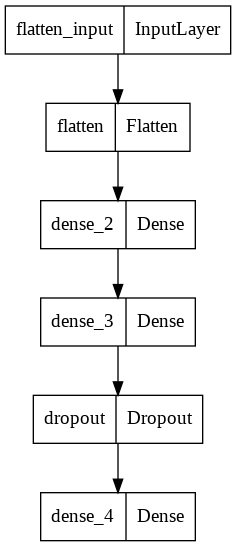

In [19]:
keras.utils.plot_model(Loading_model, 'RNN_model.png')

Выведем размерности входа и выхода каждого слоя на построенном графе

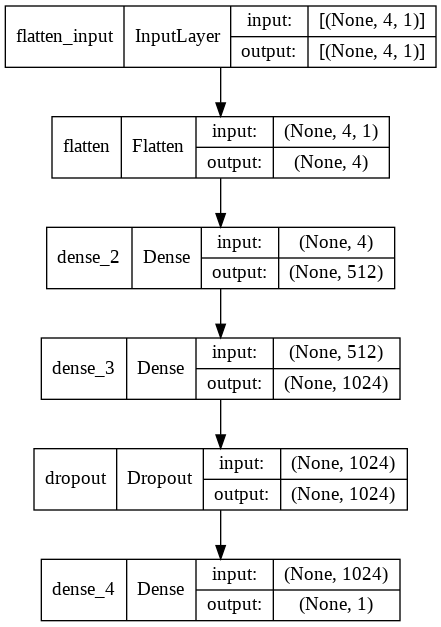

In [20]:
keras.utils.plot_model(model, 'model_with_shape_info.png', show_shapes=True)

#Проверка точности предсказания

Root Mean Square Error (RMSE) - Среднеквадратичное отклонение

In [14]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Ошибка предсказания
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Печать значений
    print('RMSE для тренировочной выборки: %.3f RMSE' % (train_rmse))
    print('RMSE для тестовой выборки: %.3f RMSE' % (test_rmse))    
 
# Сделаем предсказания
train_predict = Loading_model.predict(trainX) + Adjusting_the_prediction_result
test_predict = Loading_model.predict(testX) + Adjusting_the_prediction_result
# Среднеквадратичное отклонение
print_error(trainY, testY, train_predict, test_predict)

RMSE для тренировочной выборки: 0.016 RMSE
RMSE для тестовой выборки: 0.046 RMSE


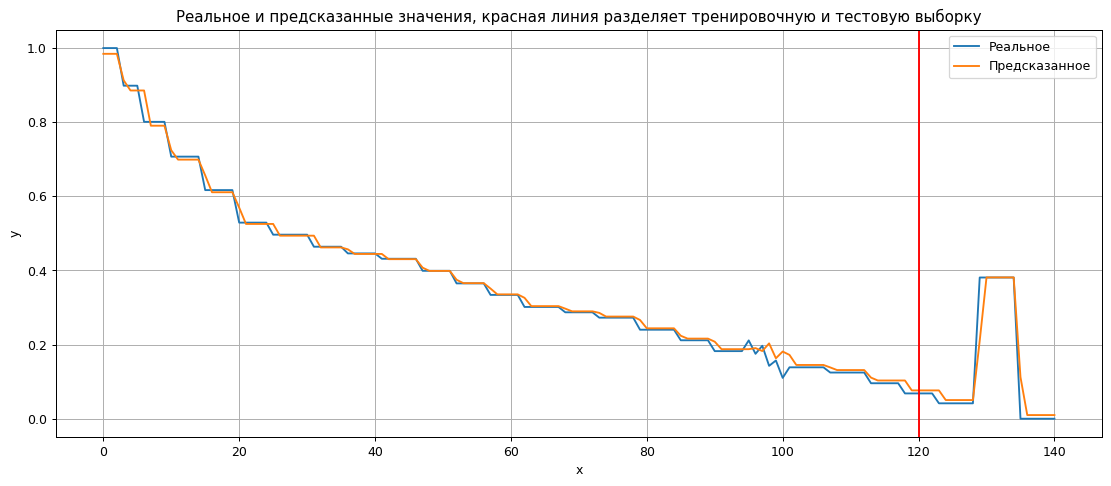

In [15]:
# График конечного результата
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(trainY, testY, train_predict, test_predict)

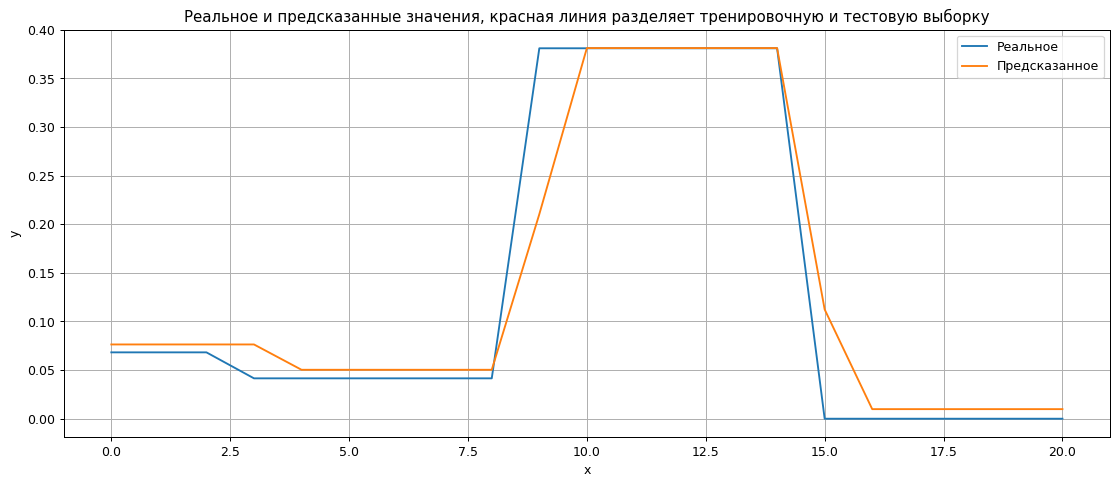

In [16]:
# График конечного результата
def plot_result(testY , test_predict):
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(testY)
    plt.plot(test_predict)
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(testY, test_predict)

Для одной переменной

In [ ]:
print ("Введите переменные")
list_of_value = []
value = float(input())
list_of_value.append(value)

k = 10
l = 14.3
data_for_predict =[[[list_of_value[0]/k]]]
data_predict = Loading_model.predict(data_for_predict) + Adjusting_the_prediction_result
y = data_predict[0] * l
print("Предсказание = ", y)

Введите переменные
-9
Предсказание =  [-10.027925]


##Проверка предсказания

Для 4-х не смаштабированных переменных

In [ ]:
print ("Введите переменные")
list_of_value = []

for i in range (0, 4):
  value = float(input())
  list_of_value.append(value)

print("Для значений: " + str(list_of_value))

data_for_predict =[[[list_of_value[0]/kt],
  [list_of_value[1]/kp],
  [list_of_value[2]/kV],
  [list_of_value[3]/kP]]]

data_predict = Loading_model.predict(data_for_predict) + Adjusting_the_prediction_result
Angle = data_predict[0] * kAngle
print("Получим: ")
print("Angle = " + str (Angle) + " градусов")
print("Расчётная мощность: ")
print(list_of_value[1]*list_of_value[2]*list_of_value[2]*list_of_value[2]/2*math.cos(Angle/57.2958))

Введите переменные
-0.7142857
1
0.085
0.000633
Для значений: [-0.7142857, 1.0, 0.085, 0.000633]
Получим: 
Angle = [0.13150148] градусов
Расчётная мощность: 
0.00030706169125372285


Для 4-х смаштабированных перенменных

In [18]:
print ("Введите переменные")
list_of_value = []

for i in range (0, 4):
  value = float(input())
  list_of_value.append(value)

print("Для значений: " + str(list_of_value))

data_for_predict =[[[list_of_value[0]],
  [list_of_value[1]],
  [list_of_value[2]],
  [list_of_value[3]]]]

data_predict = Loading_model.predict(data_for_predict) + Adjusting_the_prediction_result
Angle = data_predict[0] * kAngle
print("Получим: ")
print("Angle = " + str (Angle) + " градусов")
print("Расчётная мощность: ")
print(list_of_value[1]*list_of_value[2]*list_of_value[2]*list_of_value[2]/2*math.cos(Angle/57.2958))

Введите переменные
-0.5714286
	0.9802447
0.915
0.773948
Для значений: [-0.5714286, 0.9802447, 0.915, 0.773948]
Получим: 
Angle = [0.47661027] градусов
Расчётная мощность: 
0.37545056607693145


#Обновление обученной модели на основе только новых данных

##Загрузка новых данных

In [24]:
# Parameter split_percent defines the ratio of training examples 80% - тренировочная выборка
def get_train_test(url, split_percent = 0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

dataset_url = 'https://raw.githubusercontent.com/AnLiMan/RNN/main/Datasets/WindDatasetGen4.csv' 
new_train_data, new_test_data, new_data = get_train_test(dataset_url)

In [25]:
# Подготовка входных данных X и целевых Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = number_of_param #Количество входных данных для X
new_trainX, new_trainY = get_XY(new_train_data, time_steps)
new_testX, new_testY = get_XY(new_test_data, time_steps)

##Update модели рекуррентной нейросети

In [ ]:
# compile the model
Loading_model.compile(loss='mean_squared_error', optimizer = 'sgd', metrics=["accuracy"])
# fit the model on new data
Loading_model.fit(new_trainX, new_trainY, epochs=20, batch_size=1, verbose=2, shuffle = True)

Loading_model.summary()
# Сохраним всю модель в  HDF5 файл
#Loading_model.save("/content/drive/My Drive/Files for colab/RNN_Model_Updated" + str(number_of_interations) + ".h5")

##Update модели обычной нейросети

In [27]:
# compile the model
Loading_model.compile(loss='mean_squared_error', optimizer = 'sgd', metrics=["accuracy"])
# fit the model on new data
Loading_model.fit(trainX, trainY, epochs=20, batch_size=2, verbose=1, shuffle = True)
Loading_model.summary()

Epoch 1/20
60/60 [==============================] - 1s 5ms/step - loss: 0.0024 - accuracy: 0.0250
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 0.0250
Epoch 3/20
60/60 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 0.0250
Epoch 4/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.0250
Epoch 5/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.0250
Epoch 6/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.0250
Epoch 7/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.0250
Epoch 8/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.0250
Epoch 9/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.0250
Epoch 10/20
60/60 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 0.0250
Epoch 11/20
60/60 [

##Тест

In [28]:
def print_error(new_trainY, new_testY, new_train_predict, new_test_predict):    
    # Ошибка предсказания
    train_rmse = math.sqrt(mean_squared_error(new_trainY, new_train_predict))
    test_rmse = math.sqrt(mean_squared_error(new_testY, new_test_predict))
    # Печать отклонения
    print('RMSE для тренировочной выборки: %.3f RMSE' % (train_rmse))
    print('RMSE для тестовой выборки: %.3f RMSE' % (test_rmse))    
 
# Сделаем предсказания
new_train_predict = Loading_model.predict(new_trainX)
new_test_predict = Loading_model.predict(new_testX)
# Среднеквадратичное отклонение
print_error(new_trainY, new_testY, new_train_predict, new_test_predict)

RMSE для тренировочной выборки: 0.024 RMSE
RMSE для тестовой выборки: 0.042 RMSE


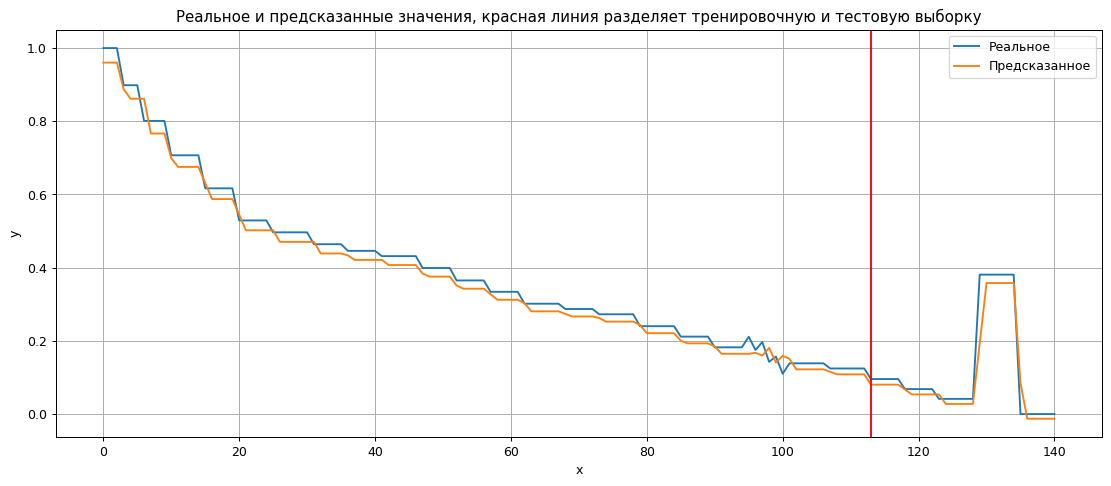

In [29]:
# График готового результата
def plot_result(new_trainY, new_testY, new_train_predict, new_test_predict):
    actual = np.append(new_trainY, new_testY)
    predictions = np.append(new_train_predict, new_test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x = len(new_trainY), color = 'r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()

plot_result(new_trainY, new_testY, new_train_predict, new_test_predict)

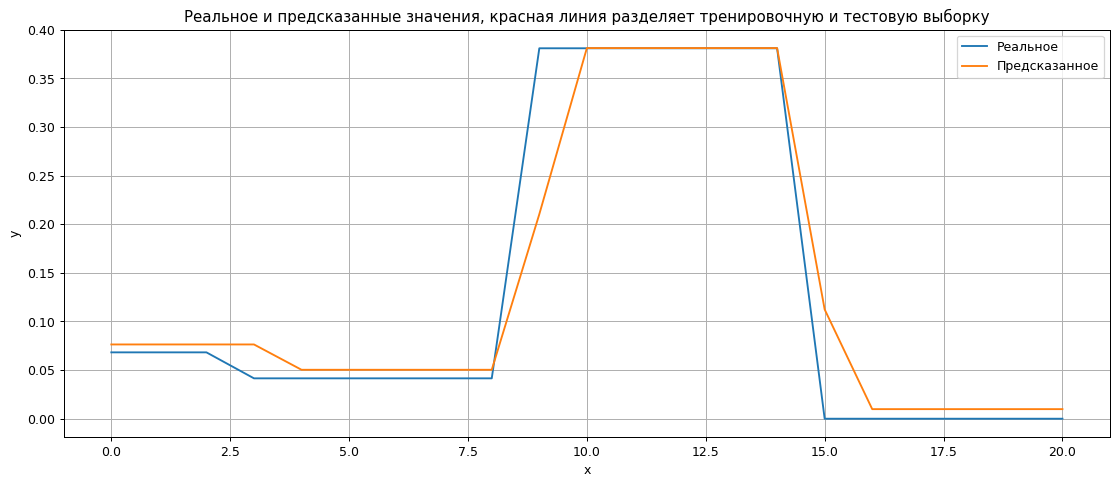

In [30]:
# График конечного результата
def plot_result(new_testY , new_test_predict):
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(testY)
    plt.plot(test_predict)
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(new_testY, new_test_predict)

#Обновление обученной модели на основе старых и новых данных

##Update модели

In [ ]:
# create a composite dataset of old and new data
X_both, y_both = vstack((trainX, new_trainX)), hstack((trainY, new_trainY))
# fit the model on old data
Loading_model.fit(X_both, y_both, epochs=150, batch_size=32, verbose=0)

Наконец, мы можем использовать обе модели вместе, чтобы делать ансамблевые прогнозы.

In [ ]:
# make predictions with both models
yhat1 = Loading_model.predict(new_testX)
yhat2 = model.predict(new_testX)

# combine predictions into single array
combined = hstack((yhat1, yhat2))

# calculate outcome as mean of predictions
yhat = mean(combined, axis=-1)

##Тест

In [ ]:
def print_error(new_and_old_trainY, new_and_old_testY, new_and_old_train_predict, new_and_old_test_predict):    
    # Ошибка предсказания
    train_rmse = math.sqrt(mean_squared_error(new_and_old_trainY, new_and_old_train_predict))
    test_rmse = math.sqrt(mean_squared_error(new_and_old_testY, new_and_old_test_predict))
    # Печать отклонения
    print('RMSE для тренировочной выборки: %.3f RMSE' % (train_rmse))
    print('RMSE для тестовой выборки: %.3f RMSE' % (test_rmse))    
 
# Сделаем предсказания
new_and_old_train_predict = Loading_model.predict(new_trainX)
new_and_old_test_predict = Loading_model.predict(new_testX)

# Среднеквадратичное отклонение
print_error(new_trainY, new_testY, new_and_old_train_predict, new_and_old_test_predict)

RMSE для тренировочной выборки: 0.101 RMSE
RMSE для тестовой выборки: 0.110 RMSE


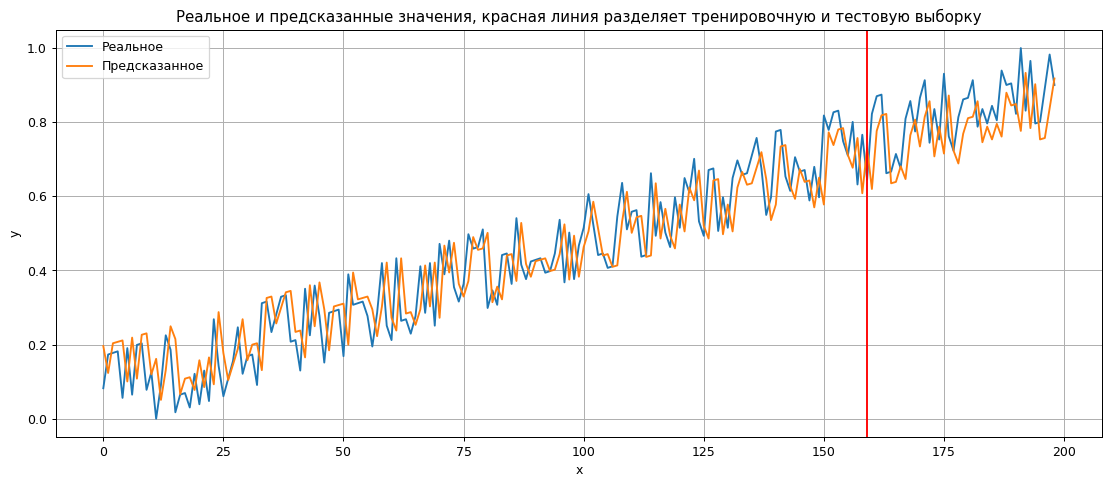

In [ ]:
# График готового результата
def plot_result(new_and_old_trainY, new_and_old_testY, new_and_old_train_predict, new_and_old_test_predict):
    actual = np.append(new_and_old_trainY, new_and_old_testY)
    predictions = np.append(new_and_old_train_predict, new_and_old_test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x = len(new_and_old_trainY), color = 'r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()

plot_result(new_trainY, new_testY, new_and_old_train_predict, new_and_old_test_predict)